In [1]:
from pathlib import Path
import glob
import exiftool
import soundfile as sf

In [2]:
import numpy as np
import scipy
import pandas as pd
import librosa
import warnings

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from bat_detect.detector import models
from cfg import get_config
from pipeline import pipeline
from utils.utils import gen_empty_df, convert_df_ravenpro
from bat_detect.utils import wavfile
import bat_detect.utils.detector_utils as du
import bat_detect.detector.compute_features as feats
import bat_detect.detector.post_process as pp

In [5]:
def plot_audio_seg(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()


def plot_dets_over_audio(audio_features, spec_features, plot_dets):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()

In [6]:
def load_audio_file(audio_file, time_exp_fact, target_samp_rate, scale=False, max_duration=False):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=wavfile.WavFileWarning)
        #sampling_rate, audio_raw = wavfile.read(audio_file)
        audio_raw, sampling_rate = librosa.load(audio_file, sr=None)

    if len(audio_raw.shape) > 1:
        raise Exception('Currently does not handle stereo files')
    sampling_rate = sampling_rate * time_exp_fact

    # resample - need to do this after correcting for time expansion
    sampling_rate_old = sampling_rate
    sampling_rate = target_samp_rate
    audio_raw = librosa.resample(audio_raw, orig_sr=sampling_rate_old, target_sr=sampling_rate, res_type='polyphase')

    # clipping maximum duration
    if max_duration is not False:
        max_duration = np.minimum(int(sampling_rate*max_duration), audio_raw.shape[0])
        audio_raw = audio_raw[:max_duration]
        
    # convert to float32 and scale
    audio_raw = audio_raw.astype(np.float32)
    if scale:
        audio_raw = audio_raw - audio_raw.mean()
        audio_raw = audio_raw / (np.abs(audio_raw).max() + 10e-6)

    return sampling_rate, audio_raw

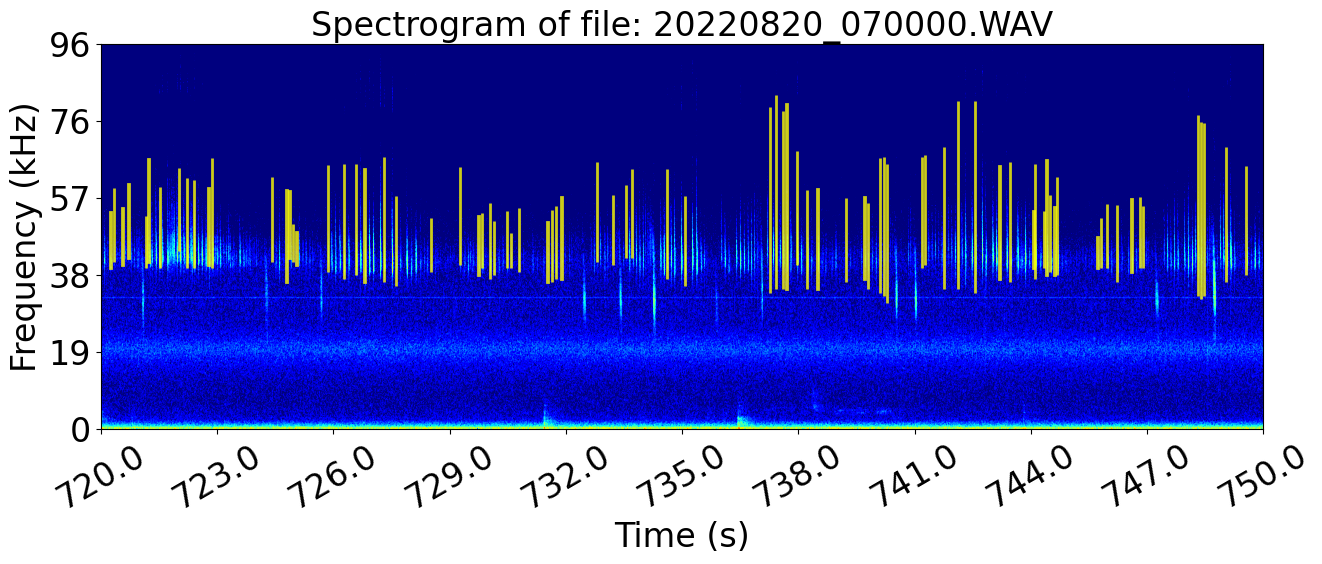

In [36]:
input_file1 = Path('../../duty-cycle-investigation/data/audiomoth_recordings/recover-20220822/Telephone/20220820_070000.WAV')
# input_file1 = Path('../../Documents/Research/Lab_related/example/original_recording/recover-20210912_unit2/UBNA_002/20210910_030000.WAV')

cfg = get_config()
cfg['input_audio'] = Path(input_file1)
cfg['tmp_dir'] = Path('../output/tmp')
cfg['output_dir'] = Path('../output_dir/recover-20210912/Foliage/')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = True

filename = input_file1.name.split('.')[0]
original_file_dets = pd.read_csv(f'../../duty-cycle-investigation/data/raw/Telephone/bd2__Telephone_{filename}.csv')
# original_file_dets = pd.read_csv(f'../output_dir/recover-20210912/Foliage/bd2_{filename}.csv')
audio_data = sf.SoundFile(input_file1)
sampling_rate = audio_data.samplerate
start = 720
file_duration = 30
audio_data.seek(int(sampling_rate*start))
audio_full = audio_data.read(int(sampling_rate*file_duration))

vmin = 20*np.log10(np.max(audio_full)) - 50 # hide anything below -rm_dB dB
vmax = 20*np.log10(np.max(audio_full)) + 0 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = input_file1
audio_features['audio_seg'] = audio_full
audio_features['sample_rate'] = sampling_rate
audio_features['start'] = start
audio_features['duration'] = file_duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax
spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"

window_cond = np.logical_and(original_file_dets['start_time'] > start, original_file_dets['end_time'] < (start+file_duration))
section_og_file_dets = original_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, section_og_file_dets)

In [37]:
sampling_rate, audio_data = load_audio_file(input_file1, 1.0, 256000)
audio_full = audio_data[int(sampling_rate*start):int(sampling_rate*(start+file_duration))]

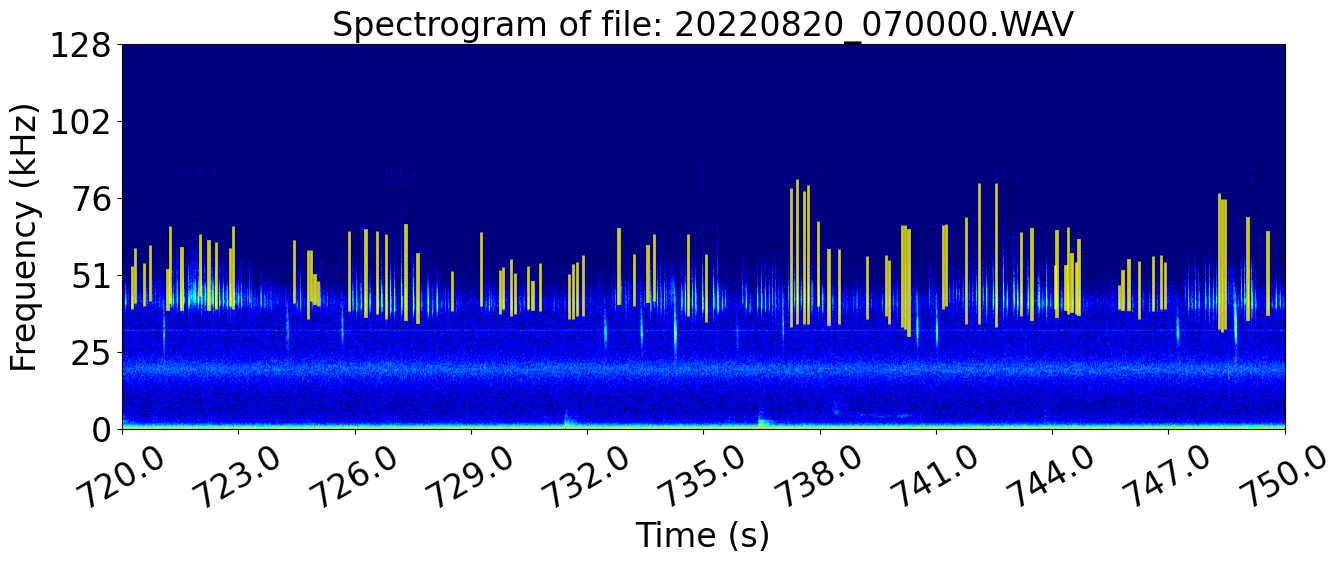

In [38]:
resamp_audio_seg = audio_data[int(sampling_rate*start):int(sampling_rate*(start+file_duration))]
vmin = 20*np.log10(np.max(resamp_audio_seg)) - 50 # hide anything below -rm_dB dB
vmax = 20*np.log10(np.max(resamp_audio_seg)) + 0 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = input_file1
audio_features['audio_seg'] = resamp_audio_seg
audio_features['sample_rate'] = 256000
audio_features['start'] = start
audio_features['duration'] = file_duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax
spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"

window_cond = np.logical_and(original_file_dets['start_time'] > start, original_file_dets['end_time'] < (start+file_duration))
section_og_file_dets = original_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, section_og_file_dets)

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_params = torch.load('../src/models/bat_call_detector/batdetect2/models/Net2DFast_UK_same.pth.tar', map_location=device)
params = net_params['params']
params['device'] = device

In [40]:
model = models.Net2DFast(params['num_filters'], num_classes=len(params['class_names']),
                            emb_dim=params['emb_dim'], ip_height=params['ip_height'],
                            resize_factor=params['resize_factor'])
model.load_state_dict(net_params['state_dict'])
model = model.to(params['device'])
model.eval()

Net2DFast(
  (conv_dn_0): ConvBlockDownCoordF(
    (conv): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_1): ConvBlockDownCoordF(
    (conv): Conv2d(33, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_2): ConvBlockDownCoordF(
    (conv): Conv2d(65, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_dn_3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1d): Conv2d(256, 256, kernel_size=(16, 1), stride=(1, 1))
  (conv_1d_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a

In [41]:
args = dict()
args['time_expansion_factor'] = 10.0
args['detection_threshold'] = 0.5
args['chunk_size'] = 0.5
args['spec_slices'] = False
args['quiet'] = False
args['spec_features'] = False
args['cnn_features'] = True

In [42]:
def run_detector_on_audio_data(model, args, params, audio_full, sampling_rate):
    # store temporary results here
    predictions = []
    spec_feats  = []
    cnn_feats   = []
    spec_slices = []

    # get time expansion  factor
    time_exp = args['time_expansion_factor']

    params['detection_threshold'] = args['detection_threshold']
    top_n=5
    # clipping maximum duration
    duration_full = audio_full.shape[0] / float(sampling_rate)

    return_np_spec = args['spec_features'] or args['spec_slices']

    # loop through larger file and split into chunks
    # TODO fix so that it overlaps correctly and takes care of duplicate detections at borders
    num_chunks = int(np.ceil(duration_full/args['chunk_size']))
    for chunk_id in range(num_chunks):

        # chunk
        chunk_time   = args['chunk_size']*chunk_id
        chunk_length = int(sampling_rate*args['chunk_size'])
        start_sample = chunk_id*chunk_length
        end_sample   = np.minimum((chunk_id+1)*chunk_length, audio_full.shape[0])
        audio = audio_full[start_sample:end_sample]

        # load audio file and compute spectrogram
        duration, spec, spec_np = du.compute_spectrogram(audio, sampling_rate, params, return_np_spec)

        # evaluate model
        with torch.no_grad():
            outputs = model(spec, return_feats=args['cnn_features'])

        # run non-max suppression
        pred_nms, features = pp.run_nms(outputs, params, np.array([float(sampling_rate)]))
        pred_nms = pred_nms[0]
        pred_nms['start_times'] += chunk_time
        pred_nms['end_times'] += chunk_time

        # if we have a background class
        if pred_nms['class_probs'].shape[0] > len(params['class_names']):
            pred_nms['class_probs'] = pred_nms['class_probs'][:-1, :]

        predictions.append(pred_nms)

        # extract features - if there are any calls detected
        if (pred_nms['det_probs'].shape[0] > 0):
            if args['spec_features']:
                spec_feats.append(feats.get_feats(spec_np, pred_nms, params))

            if args['cnn_features']:
                cnn_feats.append(features[0])

            if args['spec_slices']:
                spec_slices.extend(feats.extract_spec_slices(spec_np, pred_nms, params))

    # convert the predictions into output dictionary
    file_id = input_file1.name
    predictions, spec_feats, cnn_feats, spec_slices =\
                du.merge_results(predictions, spec_feats, cnn_feats, spec_slices)
    results = du.convert_results(file_id, time_exp, duration_full, params,
                                predictions, spec_feats, cnn_feats, spec_slices)

    # summarize results
    if not args['quiet']:
        num_detections = len(results['pred_dict']['annotation'])
        print('{}'.format(num_detections) + ' call(s) detected above the threshold.')

    # print results for top n classes
    if not args['quiet'] and (num_detections > 0):
        class_overall = pp.overall_class_pred(predictions['det_probs'], predictions['class_probs'])
        print('species name'.ljust(30) + 'probablity present')
        for cc in np.argsort(class_overall)[::-1][:top_n]:
            print(params['class_names'][cc].ljust(30) + str(round(class_overall[cc], 3)))

    annotations = results['pred_dict']['annotation']
    out_df = gen_empty_df()
    if annotations:
        out_df = pd.DataFrame.from_records(annotations) 

    return out_df

In [43]:
out_df = run_detector_on_audio_data(model, args, params, audio_full, sampling_rate)

73 call(s) detected above the threshold.
species name                  probablity present
Pipistrellus nathusii         0.528
Myotis daubentonii            0.275
Myotis brandtii               0.101
Pipistrellus pipistrellus     0.031
Myotis bechsteinii            0.018


In [44]:
out_df

,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event
0,0.2445,0.2539,40078,54140,Pipistrellus nathusii,0.504,0.631,-1,Echolocation
1,0.3345,0.3419,40937,60049,Pipistrellus nathusii,0.343,0.508,-1,Echolocation
2,0.5585,0.5658,41796,54388,Pipistrellus nathusii,0.430,0.540,-1,Echolocation
3,0.9455,0.9509,39218,56656,Pipistrellus nathusii,0.241,0.519,-1,Echolocation
4,1.1645,1.1710,40078,53138,Pipistrellus nathusii,0.371,0.579,-1,Echolocation
...,...,...,...,...,...,...,...,...,...
68,28.3815,28.3884,33203,80713,Myotis daubentonii,0.488,0.599,-1,Echolocation
69,28.4655,28.4722,33203,79533,Myotis daubentonii,0.498,0.602,-1,Echolocation
70,29.5545,29.5618,39218,66180,Pipistrellus nathusii,0.298,0.545,-1,Echolocation
71,29.6585,29.6658,39218,56010,Pipistrellus nathusii,0.346,0.504,-1,Echolocation


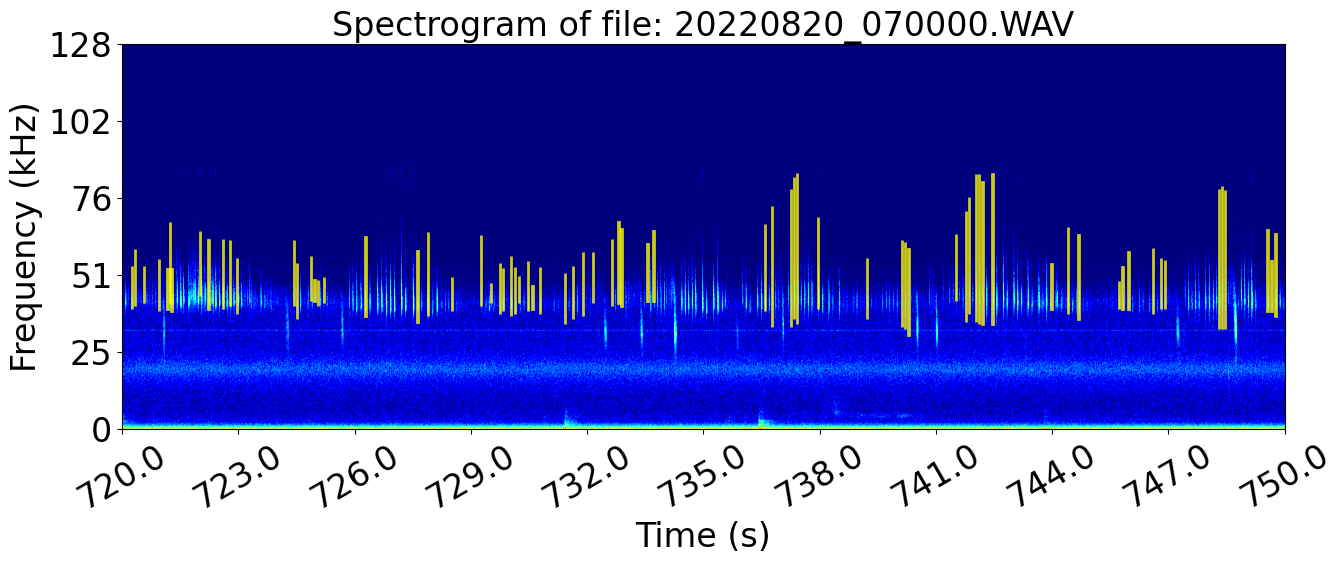

In [45]:
vmax = spec_features['vmax']
vmin = spec_features['vmin']
cmap = spec_features['cmap']
nfft = spec_features['NFFT']

plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 24})
plt.title(spec_features['plot_title'], fontsize=24)
plt.specgram(audio_full, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

ax = plt.gca()
for i, row in out_df.iterrows():
    rect = patches.Rectangle(((row['start_time'])*(sampling_rate/2), row['low_freq']/(sampling_rate/2)), 
                    (row['end_time'] - row['start_time'])*(sampling_rate/2), (row['high_freq'] - row['low_freq'])/(sampling_rate/2), 
                    linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
    ax.add_patch(rect)

plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, sampling_rate/2000, 6).astype('int'))
plot_xtype = 'float'
if (file_duration > 60):
    plot_xtype = 'int'
plt.xticks(ticks=np.linspace(0, file_duration*(sampling_rate/2), 11), 
            labels=np.round(np.linspace(start, start+file_duration, 11, dtype=plot_xtype), 2), rotation=30)
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")
plt.show()